# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 28
samples = 100

In [2]:
import time
import random
import math

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_qrack_0(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.time()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    sim.m_all()

    return time.time() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 5.435943603515625e-06, 2: 6.639957427978516e-06, 3: 8.275508880615235e-06, 4: 9.653568267822266e-06, 5: 1.1615753173828125e-05, 6: 1.3399124145507813e-05, 7: 1.497030258178711e-05, 8: 1.688241958618164e-05, 9: 1.9156932830810546e-05, 10: 2.123594284057617e-05, 11: 2.3331642150878906e-05, 12: 2.5627613067626952e-05, 13: 2.851247787475586e-05, 14: 3.083229064941406e-05, 15: 3.288507461547852e-05, 16: 3.549337387084961e-05, 17: 3.8516521453857425e-05, 18: 4.1730403900146485e-05, 19: 4.4543743133544925e-05, 20: 4.7607421875e-05, 21: 5.189180374145508e-05, 22: 5.48100471496582e-05, 23: 6.131649017333985e-05, 24: 6.920099258422852e-05, 25: 6.98685646057129e-05, 26: 7.06791877746582e-05, 27: 7.750272750854492e-05, 28: 8.081436157226562e-05}


### Random 1-qubit unitary initialization

In [5]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.time()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    sim.m_all()

    return time.time() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

{1: 7.517337799072266e-06, 2: 4.866838455200195e-05, 3: 0.00013025760650634766, 4: 0.00016870737075805664, 5: 0.00022249221801757814, 6: 0.00027956962585449217, 7: 0.0003582954406738281, 8: 0.0004593420028686523, 9: 0.0006252217292785644, 10: 0.0008205628395080567, 11: 0.0014569759368896484, 12: 0.0018095183372497559, 13: 0.002226817607879639, 14: 0.002622101306915283, 15: 0.0031099820137023924, 16: 0.003524017333984375, 17: 0.003870532512664795, 18: 0.004150452613830566, 19: 0.00537808895111084, 20: 0.00726487398147583, 21: 0.01032731294631958, 22: 0.016191232204437255, 23: 0.026669228076934816, 24: 0.04873071908950806, 25: 0.09341158390045166, 26: 0.1808786678314209, 27: 0.35194528818130494, 28: 0.6930118441581726}


## Qiskit Aer

In [6]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.time()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.time() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.0028729653358459473, 2: 0.0035223960876464844, 3: 0.0043451619148254395, 4: 0.005431456565856934, 5: 0.00662851095199585, 6: 0.00779383659362793, 7: 0.008122057914733886, 8: 0.008369221687316894, 9: 0.008751230239868164, 10: 0.009868054389953614, 11: 0.011074597835540772, 12: 0.012260918617248534, 13: 0.01330054759979248, 14: 0.014133555889129639, 15: 0.015680477619171143, 16: 0.016486101150512696, 17: 0.018218095302581786, 18: 0.020399038791656495, 19: 0.024153928756713867, 20: 0.029980273246765138, 21: 0.03977314233779907, 22: 0.0593258786201477, 23: 0.09982035398483276, 24: 0.18282557249069215, 25: 0.3504847192764282, 26: 0.7222954964637757, 27: 1.527438244819641, 28: 3.157470688819885}


## Qulacs

In [7]:
import numpy as np
import qulacs

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.time()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.time() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.0001617121696472168, 2: 0.00035918235778808593, 3: 0.0005051016807556153, 4: 0.0006431412696838379, 5: 0.0007547688484191895, 6: 0.0008967685699462891, 7: 0.0010289168357849121, 8: 0.0011959314346313477, 9: 0.0014001011848449707, 10: 0.0017623209953308106, 11: 0.0021745610237121583, 12: 0.0027056884765625, 13: 0.003195135593414307, 14: 0.0035945558547973632, 15: 0.004137895107269287, 16: 0.00657555103302002, 17: 0.010652492046356201, 18: 0.014861419200897216, 19: 0.023241722583770753, 20: 0.042334585189819335, 21: 0.0821649694442749, 22: 0.16449232816696166, 23: 0.3333674740791321, 24: 0.6579947972297668, 25: 1.3378764772415161, 26: 2.6803668928146362, 27: 5.516161546707154, 28: 11.373691477775573}


## QCGPU

In [8]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [9]:
import qcgpu

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.time()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    state.measure()

    state.backend.queue.finish()
    return time.time() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0006155848503112793, 2: 0.0010591912269592284, 3: 0.0015682554244995117, 4: 0.002197530269622803, 5: 0.0032059550285339355, 6: 0.0043785953521728515, 7: 0.005848674774169922, 8: 0.007494096755981445, 9: 0.009340126514434815, 10: 0.011453573703765868, 11: 0.01376178503036499, 12: 0.016336960792541502, 13: 0.01915686368942261, 14: 0.022216944694519042, 15: 0.02544722557067871, 16: 0.029188883304595948, 17: 0.03409884691238403, 18: 0.040013389587402345, 19: 0.04690568685531616, 20: 0.05618923425674439, 21: 0.07130575180053711, 22: 0.09571032762527466, 23: 0.1525400972366333, 24: 0.3136655592918396, 25: 0.6510699319839478, 26: 1.3500108408927918, 27: 2.804025719165802, 28: 5.893851170539856}


## Results

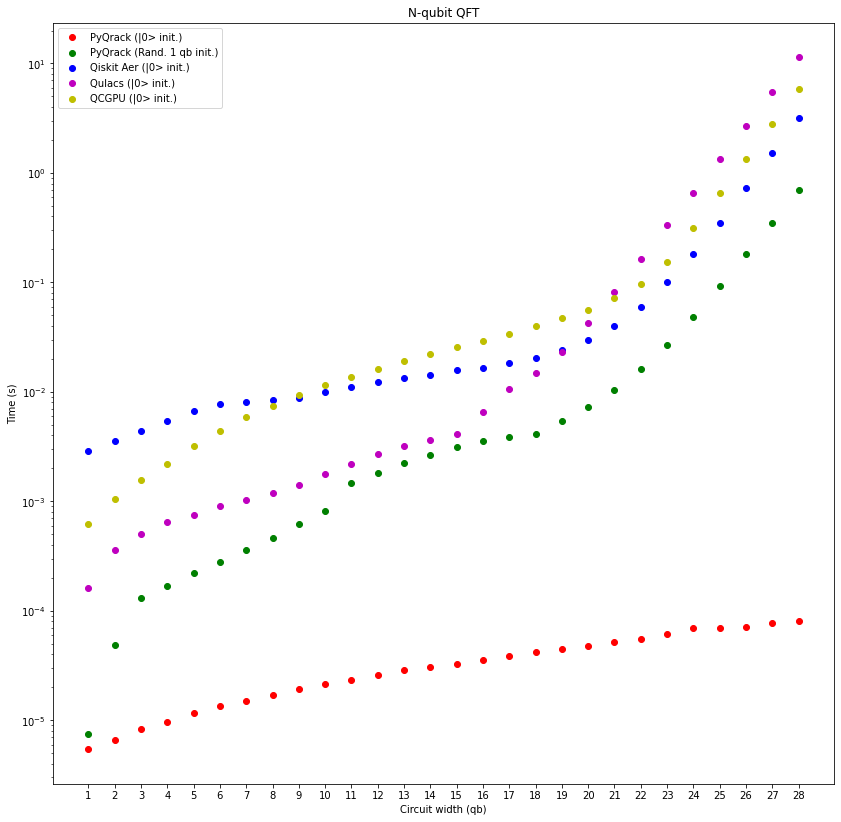

In [15]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)

colors = list("ymbgr")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(1, 29, step=1))

plt.show()

fig.savefig('qft_chart.png', dpi=100)

In [11]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2
Linux-5.19.0-32-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-32-generic', version='#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2', machine='x86_64')
Linux
x86_64


In [12]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [13]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'